# Forwards Amortised Optimisation

This notebook is designed to to be simple minimal example as a proof of concept for forwards amortised optimisation.

Note: This is running on the development version of dLux, but any existing dLux model will work!!

In [1]:
# Packages
import jax
import zodiax as zdx
import equinox as eqx
import dLux as dl
import optax

# Modules
from jax import numpy as np, random as jr, tree_util as jtu
from dLux import layers as dll, utils as dlu
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm.notebook import tqdm

# FAO imports
from lib import OptNet, Trainer, sample_normal
from plotting import plot_grid_2d, add_cbar

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 96
%matplotlib inline

## Make Optics

In [2]:
# Source parameters
wavelengths = 1e-6 * np.linspace(1., 1.2, 5)
source = dl.PointSource(wavelengths, flux=1e4)

# Wavefront parameters
wf_npix = 256
aper_diam = 2.4

# Generate an aperture manually
coords = dlu.pixel_coords(5*wf_npix, 2.4)
spider_angles = 45 + np.linspace(0, 360, 4, endpoint=False)
outer = dlu.circle(coords, aper_diam/2)
inner = dlu.circle(coords, .3, True)
spiders = dlu.spider(coords, .05, spider_angles)
aperture = dlu.combine([outer, inner, spiders], 5)

# Generate coordinates
coords = dlu.pixel_coords(wf_npix, 2.4)
zernikes = np.arange(2, 4)
basis = np.array([1e-9 * dlu.zernike(i, coords, aper_diam) for i in zernikes])
coeffs = 4e1 * jr.normal(jr.PRNGKey(0), (len(zernikes),))

# PSF parameters
psf_wf_npix = 64
sampling = 3 # ie 1.5x Nyquist
fringe_size = dlu.fringe_size(wavelengths, aper_diam).min()
psf_pix_scale = 1.22 * dlu.rad2arcsec(fringe_size) / sampling

# Construct optics & Telescope
psf_oversample = 3
layers = [('aperture', dll.BasisOptic(
    aperture, basis, coeffs, normalise=True
))]
optics = dl.AngularOptics(
    wf_npix, aper_diam, layers, psf_wf_npix, psf_pix_scale / psf_oversample
    )
fmodel = dl.Telescope(optics, source)

## Examine

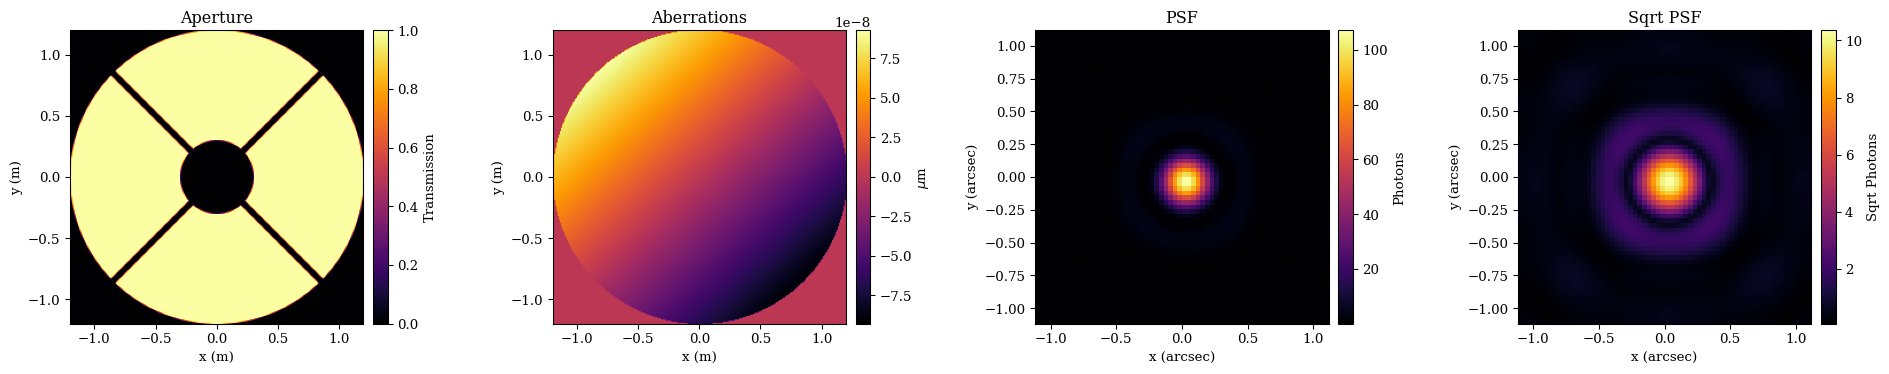

In [3]:
fig, axes = plot_grid_2d(1, 4)

# Aperture plots
r = aper_diam/2
extent = (-r, r, -r, r)

axes[0].set(xlabel='x (m)', ylabel='y (m)', title='Aperture')
im = axes[0].imshow(optics.transmission, extent=extent)
add_cbar(fig, axes[0], im, label='Transmission')

axes[1].set(xlabel='x (m)', ylabel='y (m)', title='Aberrations')
im = axes[1].imshow(optics.eval_basis(), extent=extent)
add_cbar(fig, axes[1], im, label='$\mu$m')

# PSF plots
psf = fmodel.model()
r = psf_pix_scale * psf_wf_npix / 2
extent = (-r, r, -r, r)

axes[2].set(xlabel='x (arcsec)', ylabel='y (arcsec)', title='PSF')
im = axes[2].imshow(psf, extent=extent)
add_cbar(fig, axes[2], im, label='Photons')

axes[3].set(xlabel='x (arcsec)', ylabel='y (arcsec)', title='Sqrt PSF')
im = axes[3].imshow(psf**0.5, extent=extent)
add_cbar(fig, axes[3], im, label='Sqrt Photons')
fig.tight_layout()

# Set up samples and train!

This takes ~5 minutes on my Laptop

In [4]:
# Create model & Optimise
epochs, batch_size = 1000, 100
truth = np.zeros(2)
optim = optax.adam(1e-1)

# Initialise
init_model = OptNet(fmodel, 'coefficients', depth=2, use_loss=True)
trainer = Trainer(init_model, optim) # No key, initialised to 'unity'

# Train
samples = sample_normal(epochs, batch_size, zernikes.shape, sigma=1e2, key=0)
trained = trainer.train_single(samples, truth=truth, kth=epochs//10)

Supervised training


Loss:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 	 Loss 0.040473
Epoch: 100 	 Loss -51.884
Epoch: 200 	 Loss -58.439
Epoch: 300 	 Loss -66.723
Epoch: 400 	 Loss -75.092
Epoch: 500 	 Loss -77.187
Epoch: 600 	 Loss -75.142
Epoch: 700 	 Loss -78.371
Epoch: 800 	 Loss -73.358
Epoch: 900 	 Loss -85.858
Epoch: 1000 	Loss -85.072


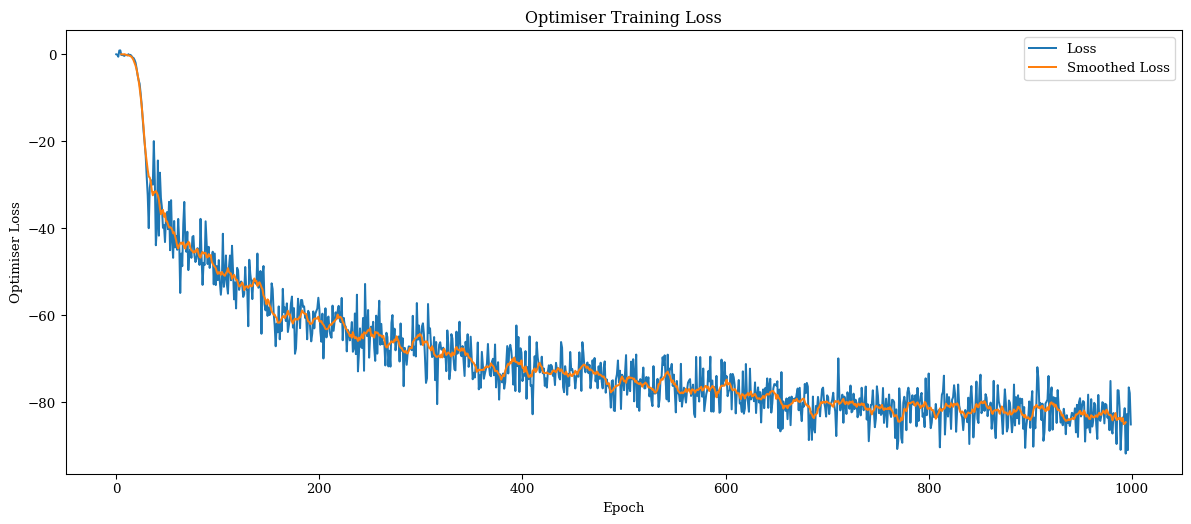

In [5]:
n = 10
take_mean = lambda arr, n: np.array([arr[i:i+n].mean() for i in range(len(arr) - n)])
smooth_losses = take_mean(trained.losses, n)
xs = np.arange(n//2, len(trained.losses)-n//2)

plt.figure(figsize=(15, 6))
plt.title("Optimiser Training Loss")
plt.plot(trained.losses, label=f'Loss')
plt.plot(xs, smooth_losses, label=f'Smoothed Loss')
plt.xlabel('Epoch')
plt.ylabel('Optimiser Loss')
plt.legend()
plt.show()

# Compare trained optimiser to SGD

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

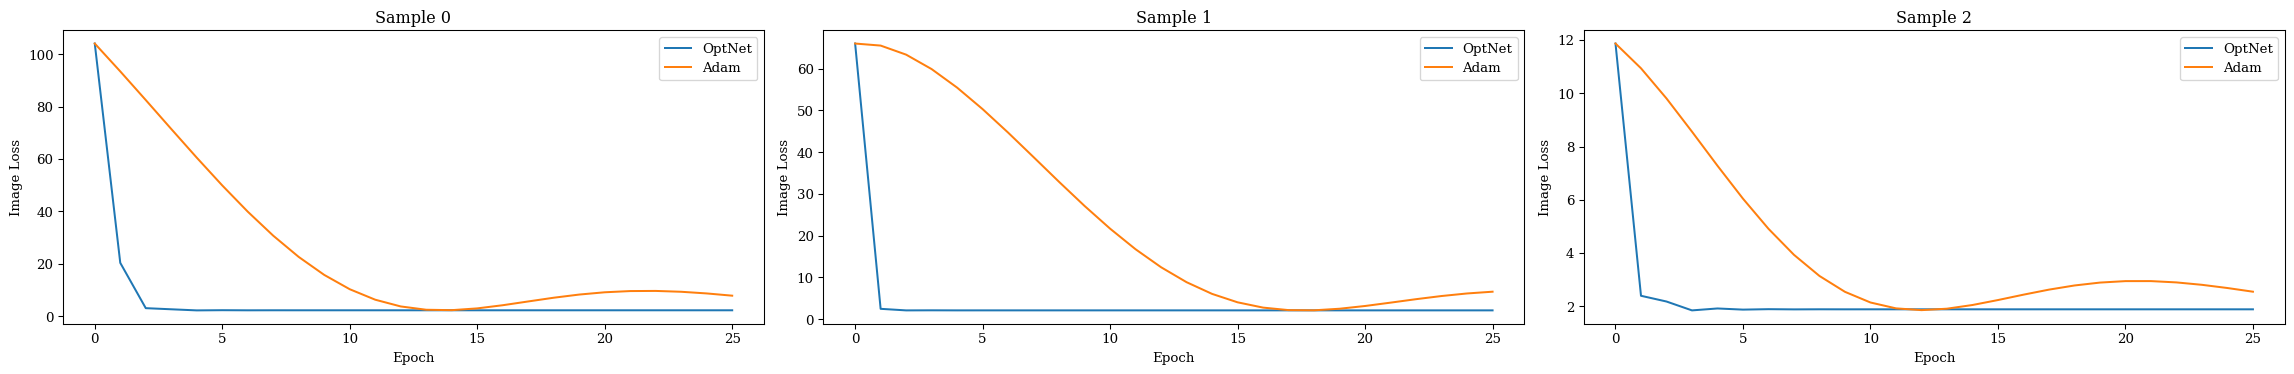

In [6]:
# Initial Conditions
key, sigma = 1, 1e2
n_samples = 3
n_epochs = 25
vals = np.squeeze(sample_normal(n_samples, 1, zernikes.shape, sigma=sigma, key=key))
update = lambda model, values: model.fmodel.set(model.params, values)

# Get the optimiser model
model = trained.model
psf = model.fmodel.model()
optim = optax.adam(1e1)
opt_state = optim.init(model.fmodel.get(model.params))
fig, axes = plot_grid_2d(1, n_samples, fsx=8)

    
for j in tqdm(range(n_samples)):
    data = jr.poisson(jr.PRNGKey(j), psf)
    initial_loss = model.image_loss(update(model, vals[j]), data)
    pred, naive = vals[j], vals[j]
    naive_losses, pred_losses = [initial_loss], [initial_loss]

    for i in tqdm(range(n_epochs), leave=False):
        # get predictions
        pred = model.predict(pred, data)
        grads = model.eval_grads(naive, data).get(model.params)
        updates, opt_state = optim.update(grads, opt_state)
        naive = zdx.apply_updates(naive, updates)

        # Get losses
        pred_losses.append(model.image_loss(update(model, pred), data))
        naive_losses.append(model.image_loss(update(model, naive), data))
    
    axes[j].set(xlabel='Epoch', ylabel='Image Loss', title=f"Sample {j}")
    axes[j].plot(pred_losses, label='OptNet')
    axes[j].plot(naive_losses, label='Adam')
    axes[j].legend()
fig.tight_layout()

### It converges in ~2 epochs, Incredible!!

# Examine the improvement from a single step

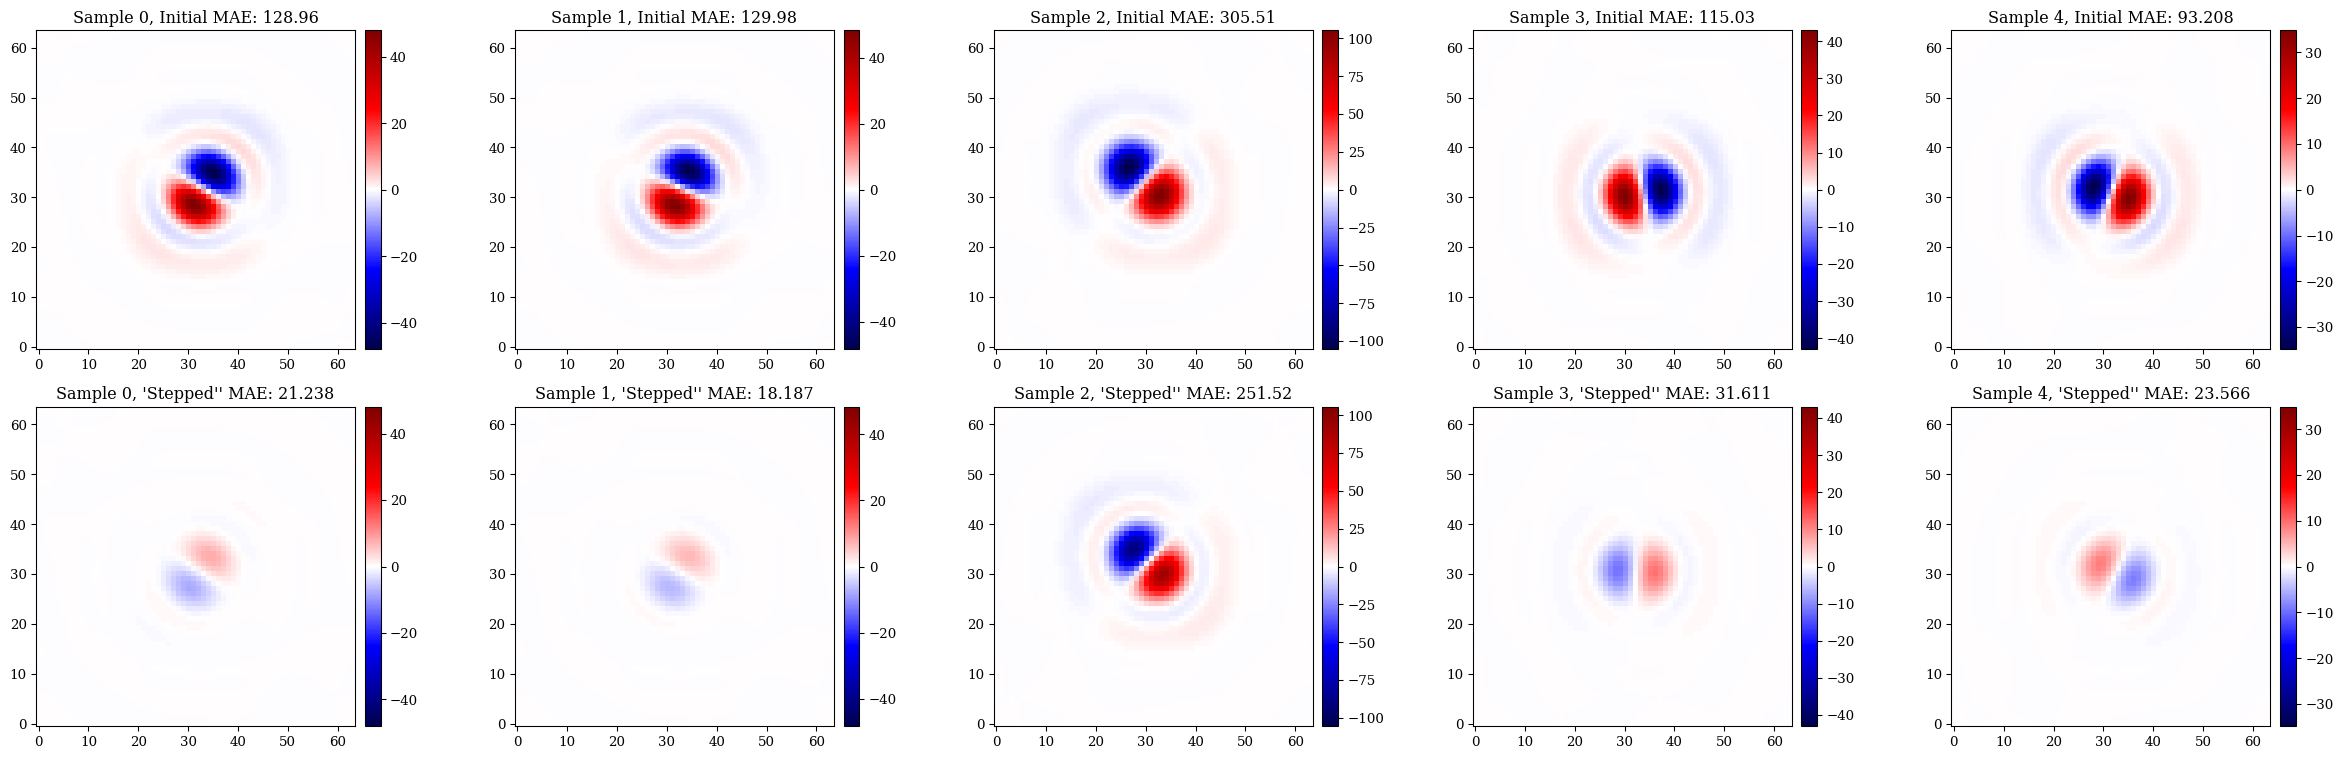

In [7]:
# Ge model and psf
model = trained.model
psf = model.fmodel.model()

# Get Residuals
rows, cols = 1, 5
init_residuals = psf[None, ...] - model.model_values(samples[0, :rows*cols])
new_values = jax.vmap(model.predict, (0, None))(samples[0, :rows*cols], psf)
final_residuals = psf[None, ...] - model.model_values(new_values)

# Get normalisation values so we have same colour scale for each sample
vmin = init_residuals.min((-1, -2))
vmax = init_residuals.max((-1, -2))
v = np.abs(np.array([vmin, vmax])).max(0)

# Get a sample of the training samples
fig, axes = plot_grid_2d(2*rows, cols)

# Plot initial values
for i in range(len(axes)//2):
    axes[i].set(xlabel='', ylabel='', title=f"Sample {i}, Initial MAE: {1e2 * np.mean(np.abs(init_residuals[i])):.5}")
    im = axes[i].imshow(init_residuals[i], vmin=-v[i], vmax=v[i], cmap='seismic')
    fig = add_cbar(fig, axes[i], im)

# Plot final values
for i in range(len(axes)//2):
    j = i + rows*cols
    axes[j].set(xlabel='', ylabel='', title=f"Sample {i}, 'Stepped'' MAE: {1e2 * np.mean(np.abs(final_residuals[i])):.5}")
    im = axes[j].imshow(final_residuals[i], vmin=-v[i], vmax=v[i], cmap='seismic')
    fig = add_cbar(fig, axes[j], im)
fig.tight_layout()

# Examine optimiser values

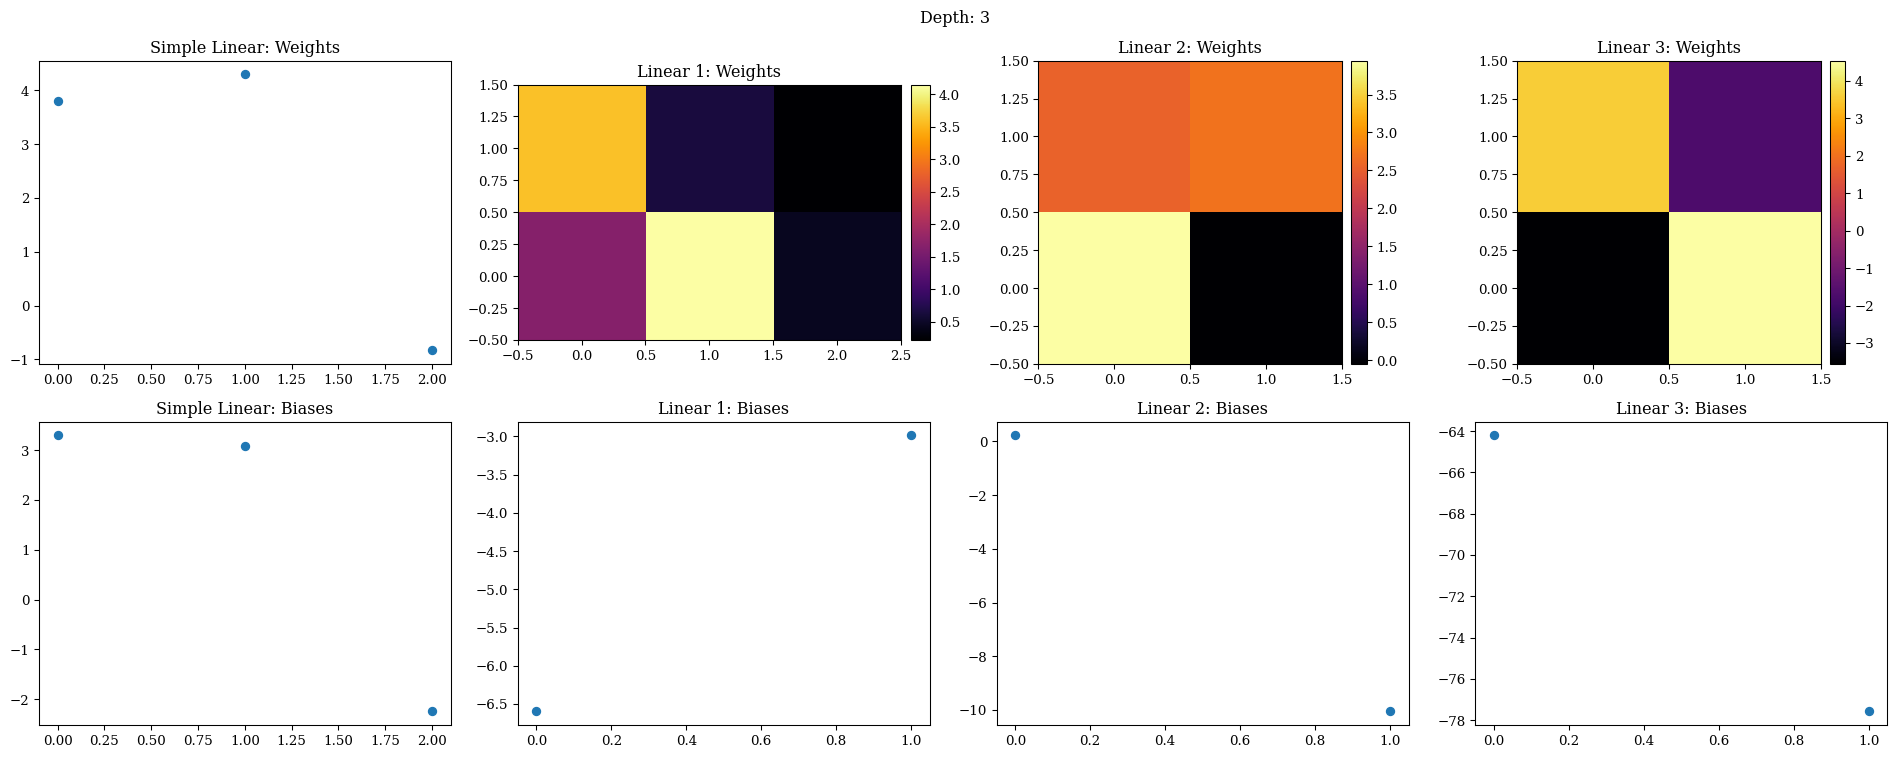

In [8]:
def visualise_optimiser(optimiser):

    layers = optimiser.layers
    depth = len(layers)
    
    fig, axes = plot_grid_2d(2, depth, fsx=5, fsy=4)
    fig.suptitle(f"Depth: {depth-1}")

    # First layer is always SimpleLinear
    xs = np.arange(len(layers[0].weight))
    axes[0].set(title="Simple Linear: Weights")
    axes[0].scatter(xs, layers[0].weight)

    axes[depth].set(title="Simple Linear: Biases")
    axes[depth].scatter(xs, layers[0].bias)

    # All other layers are Linear
    for i in range(1, depth):
        axes[i].set(title=f"Linear {i}: Weights")
        im = axes[i].imshow(layers[i].weight)
        fig = add_cbar(fig, axes[i], im)

    xs = np.arange(len(layers[1].weight))
    for j in range(1, depth):
        i = depth + j
        axes[i].set(title=f"Linear {j}: Biases")
        axes[i].scatter(xs, layers[j].bias)
    fig.tight_layout()

visualise_optimiser(trained.model.optimiser)